In [ ]:
# Package load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

# Bigger and prettier plots
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

In [ ]:
with open('model/logistic_regression.pkl', 'rb') as fp:
    logreg = pickle.load(fp)

In [ ]:
train_WoE = pd.read_pickle('model/data/train_woe_corr.pkl')
test_WoE = pd.read_pickle('model/data/test_woe_corr.pkl')
performance_df = pd.read_pickle('model/data/performance_loan_profit.pkl')

In [ ]:
drop_columns = ['mo_sin_rcnt_rev_tl_op_woe', 'revol_util_woe', 'num_actv_rev_tl_woe']

train_WoE = train_WoE.drop(drop_columns, axis = 1)



In [ ]:
performance_df['issue_d']

0         2015-12-01
1         2015-12-01
2         2015-12-01
3         2015-12-01
4         2015-12-01
             ...    
1280610   2016-10-01
1280611   2016-10-01
1280612   2016-10-01
1280613   2016-10-01
1280614   2016-10-01
Name: issue_d, Length: 1280615, dtype: datetime64[ns]

In [ ]:
train_WoE['id'] = train_WoE['id'].astype('int')
all_merged = pd.merge(train_WoE, performance_df[['funded_amnt', 'id', 'issue_d']], on=['id'])

In [ ]:
loans = pd.DataFrame(all_merged['Default'])

# loans['probs'] = 0
loans['Probs'] = pd.Series(logreg.predict_proba(all_merged.drop(['id', 'Default', 'funded_amnt', 'issue_d'], axis = 1))[:,1])

loans['Portfolio'] = all_merged['issue_d']

In [ ]:
#Last 5 years
loans = loans[loans['Portfolio'].dt.year>=2014]


# loans = loans.groupby(by='Portfolio').mean().reset_index()

# loans['Default'] = loans['Default'].astype('float')

# loans.loc[loans['Default']>0.5, 'Default'] = 1
# loans.loc[loans['Default']<0, 'Default'] = 0


In [ ]:
# #PD Calibration: The PD calibration can be done with the score, the monthly portfolio each case belongs to (usually the behavioural scorecard is used), the labels (Default / Non-Default) and a set of economic factors. For this work we will use an exchange rate and a commodity price.


# # loans = pd.read_excel('PDCalExample.xlsx',sheet_name=0)
# econ_factors = pd.read_excel('PDCalExample.xlsx',sheet_name=1)
# econ_factors=econ_factors.apply(zscore)
# fpr, tpr, thresholds = roc_curve(loans['Default'],loans['Probs'])
# import pwlf
# piecewise_AUC = pwlf.PiecewiseLinFit(fpr, tpr)
# res = piecewise_AUC.fit(10)
# cuts = piecewise_AUC.fit_with_breaks(res)
# # predict for the determined points
# xHat = np.linspace(min(fpr), max(fpr), num=10000)
# yHat = piecewise_AUC.predict(xHat)
# # Find probability associated with every cut
# ROC_curve = pd.DataFrame({'fpr': fpr, 'threshold': thresholds})
# pbb_cuts = np.zeros_like(res)
# i = 0
# for fpr in res:
#   temp = ROC_curve.loc[np.round(ROC_curve.fpr, 2) == np.round(fpr, 2), 'threshold']
#   pbb_cuts[i] = np.mean(temp)
#   i += 1
# pbb_cuts = np.flip(pbb_cuts)
# pbb_cuts = np.append(pbb_cuts, 1)
# pbb_cuts = np.insert(pbb_cuts, 0, 0)
# pd_cut = pd.cut(loans['Probs'], pbb_cuts)
# # Create table with cases total.
# PDs_Tab = pd.crosstab(pd_cut,loans['Default'],normalize = False)
# # Calculate default rate.
# pd_final = PDs_Tab[1] / (PDs_Tab[0] + PDs_Tab[1])#The PD is perfectly monotonous!
# # Adjusted cuts
# pbb_cuts = [0.00000000e+00, 2.28978031e-01, # Delete first cut
#             3.43684010e-01, 4.29913660e-01, 5.55186700e-01, 6.94758101e-01,
#             7.51302438e-01, 8.26511005e-01, 9.11724503e-01, 9.82918518e-01,
#             1.00000000e+00]

# # Add the PDCut variable to our dataframe
# loans['PD_Cut'] = pd.cut(loans['Probs'], pbb_cuts)

# # Create pivot table
# PD_monthly = pd.pivot_table(loans,
#                             values = 'Default',
#                             index = 'Portfolio',
#                             columns = 'PD_Cut',
#                             aggfunc = np.mean
#                             )#Now we have calculated the PDs for all ratings! 

# #Let's plot how our ratings look like
# PD_monthly.plot(subplots=True,
#           layout=(2, 5),
#           sharex=False,
#           sharey=False,
#           colormap='viridis',
#          fontsize=8,
#          legend=False,
#          linewidth=0.2);
# plt.tight_layout();
# #Estimating Long-Term PD
# from datetime import date
# from dateutil.relativedelta import *

# start_date = date(1999, 1, 1)
# PD_monthly.index = [pd.to_datetime(start_date + relativedelta(months=+portfolio_month-1)) for portfolio_month in PD_monthly.index] 
# econ_factors.index = [pd.to_datetime(start_date + relativedelta(months=+portfolio_month-1)) for portfolio_month in econ_factors.index] 
# econ_factors.drop(columns='Portfolio', inplace = True)
# #Now we can decompose our time series to see what is happening.
# from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition = seasonal_decompose(PD_monthly.iloc[:, 4], model='additive')
# fig = decomposition.plot()
# plt.show()
# #Let's search for the best model for a rating, searching between 1 and 6 autoregression factors, using the macroeconomic factors as the exogenous variables:
# # Define the search space.
# p = range(1, 6)
# d = range(0, 2)
# q = range(0, 2)

# # Create an interative list of ps, ds, qs.
# from itertools import product
# pdq = list(product(p, d, q))

# # Seasonal parameters. One year back.
# ps = range(0, 4)
# ds = range(0, 1)
# qs = range(0, 1)
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

# # Train the models for a series and test multiple values.
# y = PD_monthly.iloc[:, 4] # Choose the fifth rating

# from statsmodels.tsa.statespace.sarimax import SARIMAX

# auc_out = []

# for param in pdq:
#   for param_seasonal in seasonal_pdq:
#       mod = SARIMAX(y,
#                     exog=np.asarray(econ_factors),
#                     order=param,
#                     seasonal_order=param_seasonal,
#                     enforce_stationarity=False,
#                     enforce_invertibility=False
#                     )
#       results = mod.fit()
#       auc_out.append([param, param_seasonal, results.aic])
#       print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
# # ARIMA(5, 0, 1)x(0, 0, 0, 12)12
# mod_BB = SARIMAX(y,
#               exog=np.asarray(econ_factors),
#               order=(5,0,1),
#               seasonal_order=(0,0,0,12),
#               enforce_stationarity=False,
#               enforce_invertibility=False)
# results_BB = mod_BB.fit()

# print(results_BB.summary().tables[1])
# # ARIMA(4, 1, 1)x(0, 0, 0, 12)12
# mod_BB = SARIMAX(y,
#               exog=np.asarray(econ_factors),
#               order=(4,1,1),
#               seasonal_order=(0,0,0,12),
#               enforce_stationarity=False,
#               enforce_invertibility=False)
# results_BB = mod_BB.fit()

# print(results_BB.summary().tables[1])#We pick the one that minimizes the AIC, which is ARIMA(1, 0, 1)x(0, 0, 0, 12).


In [ ]:
cpi = pd.read_csv('model/data/cpi.csv')
interest_rate = pd.read_csv('model/data/interest_rates.csv')
relative_cpi = pd.read_csv('model/data/relative_cpi.csv')


In [ ]:
interest_rate = interest_rate[interest_rate['SUBJECT'] == 'IRLT']

In [ ]:
relative_cpi

,SUBJECT,Subject,LOCATION,Country,FREQUENCY,Frequency,TIME,Time,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,CCRETT01,Relative consumer price indices,CAN,Canada,M,Monthly,2013-11,Nov-2013,IDX,Index,0,Units,2010_100,2010=100,116.13040,NaN,NaN
1,CCRETT01,Relative consumer price indices,CAN,Canada,M,Monthly,2013-12,Dec-2013,IDX,Index,0,Units,2010_100,2010=100,114.14130,NaN,NaN
2,CCRETT01,Relative consumer price indices,CAN,Canada,M,Monthly,2014-01,Jan-2014,IDX,Index,0,Units,2010_100,2010=100,111.21120,NaN,NaN
3,CCRETT01,Relative consumer price indices,CAN,Canada,M,Monthly,2014-02,Feb-2014,IDX,Index,0,Units,2010_100,2010=100,110.50390,NaN,NaN
4,CCRETT01,Relative consumer price indices,CAN,Canada,M,Monthly,2014-03,Mar-2014,IDX,Index,0,Units,2010_100,2010=100,110.02740,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,CCRETT01,Relative consumer price indices,CAN,Canada,M,Monthly,2018-10,Oct-2018,IDX,Index,0,Units,2010_100,2010=100,99.01038,NaN,NaN
60,CCRETT01,Relative consumer price indices,CAN,Canada,M,Monthly,2018-11,Nov-2018,IDX,Index,0,Units,2010_100,2010=100,97.62258,NaN,NaN
61,CCRETT01,Relative consumer price indices,CAN,Canada,M,Monthly,2018-12,Dec-2018,IDX,Index,0,Units,2010_100,2010=100,95.88209,NaN,NaN
62,CCRETT01,Relative consumer price indices,CAN,Canada,M,Monthly,2019-01,Jan-2019,IDX,Index,0,Units,2010_100,2010=100,96.43324,NaN,NaN


In [ ]:
cpi['TIME']  = pd.to_datetime(cpi['TIME'])
cpi = cpi[['TIME', 'Value']]
cpi.columns = ['Portfolio', 'cpi']
# relative_cpi['TIME']  = pd.to_datetime(relative_cpi['TIME'])
# relative_cpi = relative_cpi[['TIME', 'Value']]
# relative_cpi.columns = ['Portfolio', 'relative_cpi']
interest_rate['TIME'] = pd.to_datetime(interest_rate['TIME'])
interest_rate = interest_rate[['TIME','Value']]
interest_rate.columns= ['Portfolio', 'int_rate']

In [ ]:
months

58.97451693053245

In [ ]:
min_date = loans['Portfolio'].min()
max_date = loans['Portfolio'].max()

months = (max_date - min_date)/np.timedelta64(1, 'M')

dates = pd.date_range(min_date,max_date, 
              freq='MS').strftime("%Y-%m-01")
dates = pd.to_datetime(dates)

date_map, inv_date_map = {}, {}
for i,date in enumerate(dates):
    date_map[date] = i
    inv_date_map[i] = date

In [ ]:
loans['Portfolio'] = loans['Portfolio'].replace(date_map)

In [ ]:
econ_factors = cpi.merge(interest_rate, on=['Portfolio'], how='inner') #.merge(relative_cpi, on=['Portfolio'], how = 'inner')
# interest_rate[interest_rate['Portfolio']==interest_rate['Portfolio'][0]]

In [ ]:
# econ_factors.loc[min(dates),:]
# cpi.loc[min(dates),:]
# cpi.loc[cpi['Portfolio'] >=pd.to_datetime(dates).min(),:]
dates.min()

Timestamp('2014-01-01 00:00:00')

In [ ]:
econ_factors = econ_factors[(econ_factors['Portfolio']<=dates.max()) & (econ_factors['Portfolio']>=dates.min())]
# econ_factors

In [ ]:
# econ_factors['Portfolio'] = econ_factors['Portfolio'].replace(date_map)

In [ ]:
# loans.columns = ['Default', 'Probs', 'Date', 'Portfolio']
# loans

In [ ]:
# econ_factors.columns = ['Date', 'cpi', 'int_rate', 'Portfolio']
# econ_factors

In [ ]:
from scipy.stats import zscore
econ_factors=econ_factors.set_index(['Portfolio']).apply(zscore)
econ_factors.describe()


,cpi,int_rate
count,6.000000e+01,6.000000e+01
mean,2.590520e-17,-2.090920e-16
std,1.008439e+00,1.008439e+00
min,-1.935495e+00,-1.781166e+00
25%,-9.073207e-01,-8.302442e-01
50%,1.732664e-01,6.434333e-03
75%,7.837625e-01,8.837967e-01
max,1.850298e+00,1.666681e+00


In [ ]:
loans

,Default,Probs,Portfolio
0,0,0.301161,23
1,0,0.267092,23
2,0,0.332763,23
3,1,0.619653,23
4,0,0.448231,23
...,...,...,...
896425,1,0.269786,33
896426,0,0.302501,33
896427,0,0.551921,33
896428,1,0.639096,33


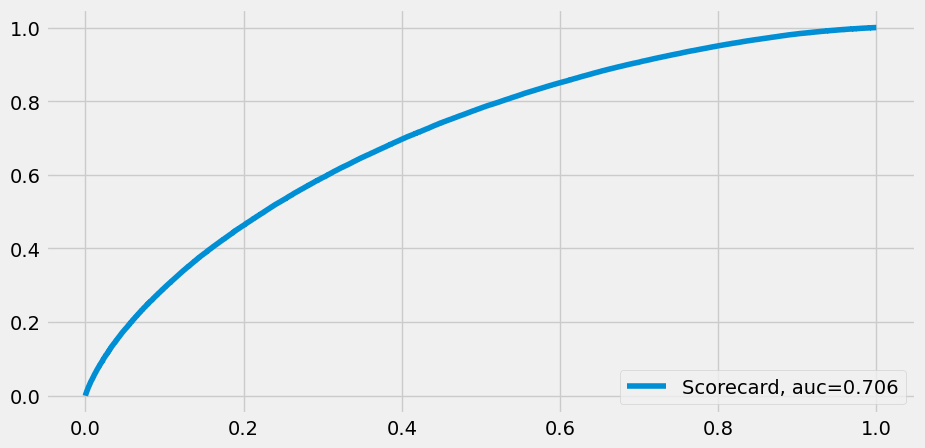

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(loans['Default'], 
                                 loans['Probs'])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = loans['Default'], 
                             y_score = loans['Probs']),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Scorecard, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# !pip install pwlf

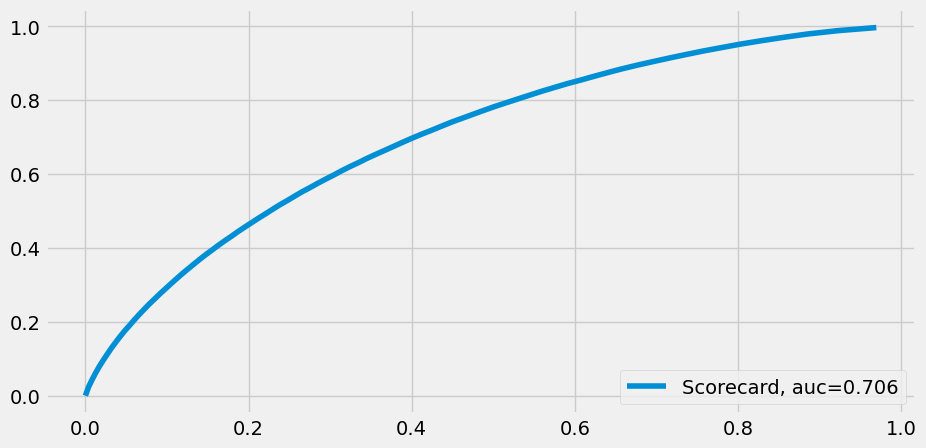

In [ ]:
# Create and show the plot
plt.plot(fpr[::3000],tpr[::3000],label="Scorecard, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
import pwlf

# Define the curve with the ROC curve
piecewise_AUC = pwlf.PiecewiseLinFit(fpr[::3000], tpr[::3000])

In [ ]:
# Calculate the best curve. Long!
res = piecewise_AUC.fit(12)

In [ ]:
res

array([0.        , 0.01041598, 0.03875628, 0.07501903, 0.122853  ,
       0.17565724, 0.25954088, 0.34928536, 0.45507255, 0.57914431,
       0.70196576, 0.845405  , 0.96956871])

In [ ]:
ROC_curve = pd.DataFrame({'fpr': fpr, 'threshold': thresholds})
ROC_curve

,fpr,threshold
0,0.000000,1.907895
1,0.000000,0.907895
2,0.000003,0.904152
3,0.000003,0.902913
4,0.000005,0.902013
...,...,...
247462,0.999830,0.030270
247463,0.999833,0.030244
247464,0.999942,0.025301
247465,0.999942,0.025197


In [ ]:
cuts = piecewise_AUC.fit_with_breaks(res)

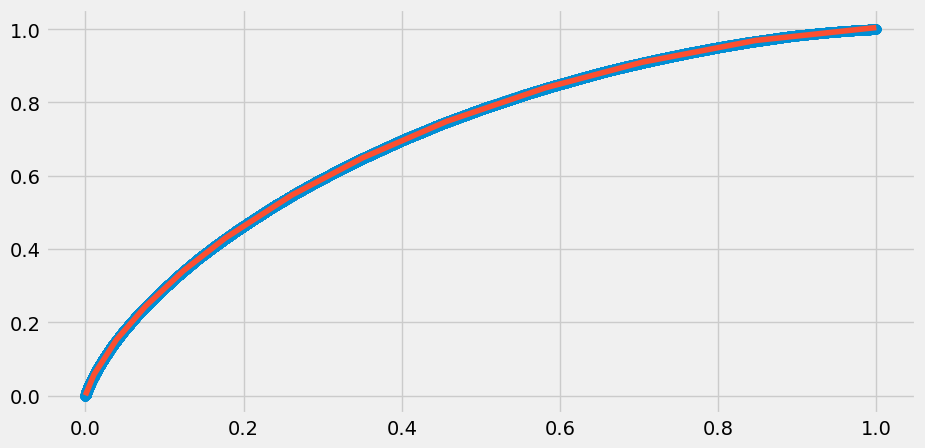

In [ ]:
# predict for the determined points
xHat = np.linspace(min(fpr), max(fpr), num=10000)
yHat = piecewise_AUC.predict(xHat)

# plot the results
plt.figure()
plt.plot(fpr, tpr, 'o')
plt.plot(xHat, yHat, '-')
plt.show()

In [ ]:
# Find probability associated with every cut
pbb_cuts = np.zeros_like(res)
i = 0

for fpr in res:
    temp = ROC_curve.loc[np.round(ROC_curve.fpr, 2) == np.round(fpr, 2), 'threshold']
    pbb_cuts[i] = np.mean(temp)
    i += 1

pbb_cuts = np.flip(pbb_cuts)

In [ ]:
pbb_cuts = np.append(pbb_cuts, 1)
pbb_cuts = np.insert(pbb_cuts, 0, 0)
pbb_cuts

array([0.        , 0.12149061, 0.23331678, 0.32185746, 0.38305963,
       0.4425346 , 0.4988231 , 0.54833749, 0.59867105, 0.64278629,
       0.67895432, 0.72692611, 0.79315141, 0.83772397, 1.        ])

In [ ]:
pd_cut = pd.cut(loans['Probs'], pbb_cuts)
pd_cut

0         (0.233, 0.322]
1         (0.233, 0.322]
2         (0.322, 0.383]
3         (0.599, 0.643]
4         (0.443, 0.499]
               ...      
896425    (0.233, 0.322]
896426    (0.233, 0.322]
896427    (0.548, 0.599]
896428    (0.599, 0.643]
896429    (0.548, 0.599]
Name: Probs, Length: 804303, dtype: category
Categories (14, interval[float64, right]): [(0.0, 0.121] < (0.121, 0.233] < (0.233, 0.322] < (0.322, 0.383] ... (0.679, 0.727] < (0.727, 0.793] < (0.793, 0.838] < (0.838, 1.0]]

In [ ]:
# Create table with cases total.
PDs_Tab = pd.crosstab(pd_cut,
                      loans['Default'],
                      normalize = False)

# Calculate default rate.
print(PDs_Tab)
pd_final = PDs_Tab[1] / (PDs_Tab[0] + PDs_Tab[1])
pd_final

Default             0      1
Probs                       
(0.0, 0.121]    19181    592
(0.121, 0.233]  76863   4657
(0.233, 0.322]  96079  10083
(0.322, 0.383]  77070  11212
(0.383, 0.443]  76932  14376
(0.443, 0.499]  70609  16704
(0.499, 0.548]  57562  16754
(0.548, 0.599]  51411  18243
(0.599, 0.643]  38350  16374
(0.643, 0.679]  25719  13274
(0.679, 0.727]  25625  16168
(0.727, 0.793]  19353  16730
(0.793, 0.838]   4952   5993
(0.838, 1.0]     1279   2158


Probs
(0.0, 0.121]      0.029940
(0.121, 0.233]    0.057127
(0.233, 0.322]    0.094977
(0.322, 0.383]    0.127002
(0.383, 0.443]    0.157445
(0.443, 0.499]    0.191312
(0.499, 0.548]    0.225443
(0.548, 0.599]    0.261909
(0.599, 0.643]    0.299211
(0.643, 0.679]    0.340420
(0.679, 0.727]    0.386859
(0.727, 0.793]    0.463653
(0.793, 0.838]    0.547556
(0.838, 1.0]      0.627873
dtype: float64

In [ ]:
# Add the PDCut variable to our dataframe

pbb_cuts = np.array([0.        , 0.2240886 , 0.32884169, 0.41127243,
       0.47673336, 0.53453134, 0.58691349, 0.62674276, 0.6662282 ,
       0.70537213, 0.74685202, 0.79559575,  1.        ])

loans['PD_Cut'] = pd.cut(loans['Probs'], pbb_cuts)

# Create pivot table
PD_monthly = pd.pivot_table(loans,
                            values = 'Default',
                            index = 'Portfolio',
                            columns = 'PD_Cut',
                            aggfunc = np.mean
                            )

PD_monthly

PD_Cut,"(0.0, 0.224]","(0.224, 0.329]","(0.329, 0.411]","(0.411, 0.477]","(0.477, 0.535]","(0.535, 0.587]","(0.587, 0.627]","(0.627, 0.666]","(0.666, 0.705]","(0.705, 0.747]","(0.747, 0.796]","(0.796, 1.0]"
Portfolio,,,,,,,,,,,,
0,0.091837,0.093645,0.151874,0.149606,0.165796,0.250299,0.288136,0.318759,0.362253,0.374312,0.493213,0.480952
1,0.038095,0.074576,0.119919,0.186992,0.211829,0.260816,0.272214,0.351724,0.385762,0.409247,0.438356,0.521008
2,0.013333,0.088561,0.147917,0.152941,0.225585,0.231850,0.236531,0.301353,0.378415,0.397849,0.495010,0.585714
3,0.064815,0.114286,0.131439,0.186842,0.248292,0.237358,0.268765,0.311703,0.366828,0.406977,0.500000,0.569733
4,0.021898,0.098930,0.120438,0.188791,0.232506,0.273931,0.316667,0.338513,0.366150,0.401471,0.442177,0.522727
5,0.010753,0.099338,0.136821,0.226772,0.226752,0.273212,0.301129,0.355000,0.386364,0.423077,0.515596,0.534884
6,0.036810,0.079186,0.152585,0.169317,0.212970,0.255699,0.302651,0.301541,0.365164,0.415219,0.457831,0.561279
7,0.087591,0.068602,0.130225,0.178231,0.220588,0.285132,0.320497,0.327068,0.371921,0.427536,0.475329,0.585302
8,0.051948,0.076305,0.156499,0.195181,0.246465,0.282528,0.260215,0.376940,0.394673,0.468137,0.491909,0.569832


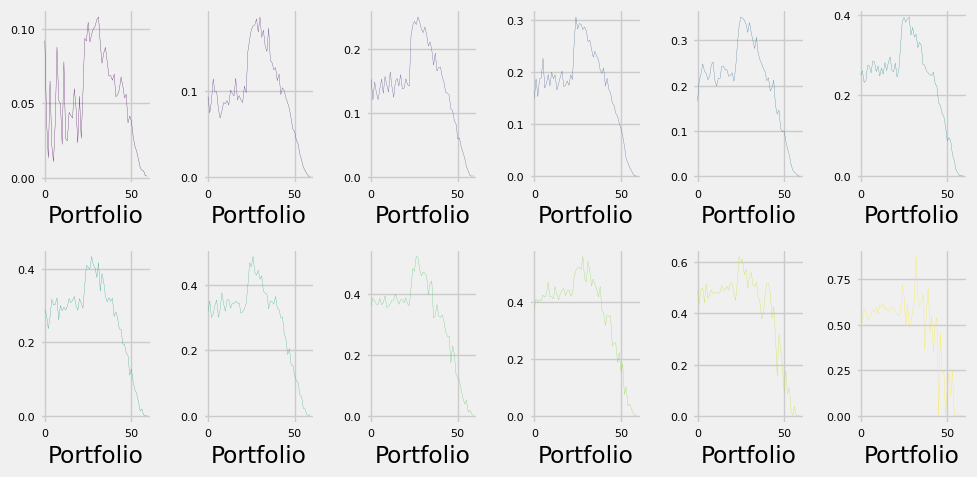

In [ ]:
PD_monthly.plot(subplots=True,
          layout=(2, 6),
          sharex=False,
          sharey=False,
          colormap='viridis',
         fontsize=8,
         legend=False,
         linewidth=0.2);
plt.tight_layout();

In [ ]:

PD_monthly

PD_Cut,"(0.0, 0.224]","(0.224, 0.329]","(0.329, 0.411]","(0.411, 0.477]","(0.477, 0.535]","(0.535, 0.587]","(0.587, 0.627]","(0.627, 0.666]","(0.666, 0.705]","(0.705, 0.747]","(0.747, 0.796]","(0.796, 1.0]"
Portfolio,,,,,,,,,,,,
0,0.091837,0.093645,0.151874,0.149606,0.165796,0.250299,0.288136,0.318759,0.362253,0.374312,0.493213,0.480952
1,0.038095,0.074576,0.119919,0.186992,0.211829,0.260816,0.272214,0.351724,0.385762,0.409247,0.438356,0.521008
2,0.013333,0.088561,0.147917,0.152941,0.225585,0.231850,0.236531,0.301353,0.378415,0.397849,0.495010,0.585714
3,0.064815,0.114286,0.131439,0.186842,0.248292,0.237358,0.268765,0.311703,0.366828,0.406977,0.500000,0.569733
4,0.021898,0.098930,0.120438,0.188791,0.232506,0.273931,0.316667,0.338513,0.366150,0.401471,0.442177,0.522727
5,0.010753,0.099338,0.136821,0.226772,0.226752,0.273212,0.301129,0.355000,0.386364,0.423077,0.515596,0.534884
6,0.036810,0.079186,0.152585,0.169317,0.212970,0.255699,0.302651,0.301541,0.365164,0.415219,0.457831,0.561279
7,0.087591,0.068602,0.130225,0.178231,0.220588,0.285132,0.320497,0.327068,0.371921,0.427536,0.475329,0.585302
8,0.051948,0.076305,0.156499,0.195181,0.246465,0.282528,0.260215,0.376940,0.394673,0.468137,0.491909,0.569832


In [ ]:
PD_monthly.index = PD_monthly.reset_index()['Portfolio'].replace(inv_date_map)
# PD_monthly.index.replace(inv_date_map)

In [ ]:
# from datetime import date
# from dateutil.relativedelta import *

# start_date = date(2013, 1, 1)
# PD_monthly.index = [pd.to_datetime(start_date + relativedelta(months=+portfolio_month-1)) for portfolio_month in PD_monthly.index] 
# econ_factors.index = [pd.to_datetime(start_date + relativedelta(months=+portfolio_month-1)) for portfolio_month in econ_factors.index] 
# econ_factors.drop(columns='Portfolio', inplace = True)

In [ ]:
econ_factors
PD_monthly.index = pd.to_datetime(PD_monthly.index)

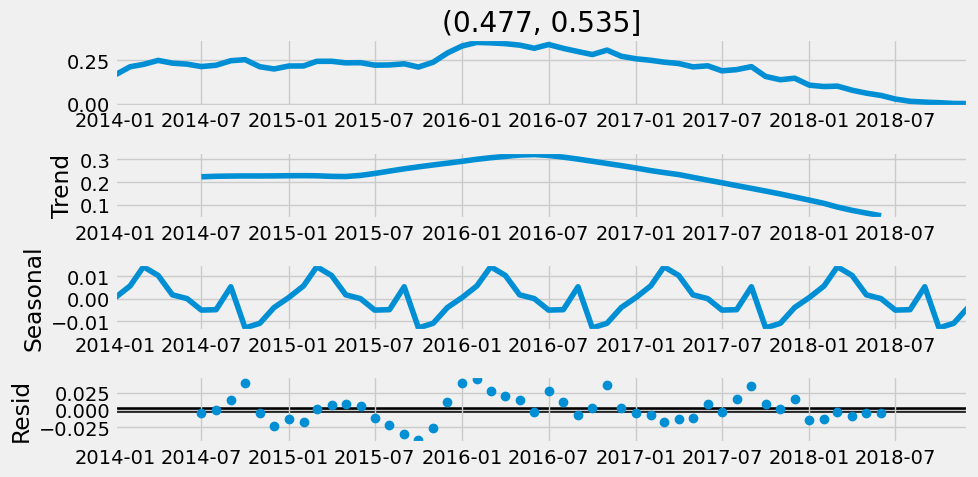

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(PD_monthly.iloc[:, 4], model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
# Define the search space.
p = range(1, 6)
d = range(0, 2)
q = range(0, 2)

# Create an interative list of ps, ds, qs.
from itertools import product
pdq = list(product(p, d, q))

# Seasonal parameters. One year back.
ps = range(0, 4)
ds = range(0, 1)
qs = range(0, 1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

# Train the models for a series and test multiple values.
y = PD_monthly.iloc[:, 4] # Choose the fifth rating

from statsmodels.tsa.statespace.sarimax import SARIMAX

auc_out = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = SARIMAX(y,
                    exog=np.asarray(econ_factors),
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                    )
        results = mod.fit()
        auc_out.append([param, param_seasonal, results.aic])
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-284.5479207472574
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-226.6518629087153
ARIMA(1, 0, 0)x(2, 0, 0, 12)12 - AIC:-173.70343982698742


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0)x(3, 0, 0, 12)12 - AIC:-113.53171659124388
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-283.5638747522805
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-225.9938749320866


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:-172.75133021313272
ARIMA(1, 0, 1)x(3, 0, 0, 12)12 - AIC:-111.52863022431251
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-284.7427770594399
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-221.22164650387498


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(1, 1, 0)x(2, 0, 0, 12)12 - AIC:-162.4635188301098


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(3, 0, 0, 12)12 - AIC:-103.29778384077844
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-278.7337137644014


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-221.26895026969507
ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:-160.48760401918565


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(1, 1, 1)x(3, 0, 0, 12)12 - AIC:-101.33954199299184
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:-283.961587807843
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:-220.18215112927626


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:-169.3092365555865


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(2, 0, 0)x(3, 0, 0, 12)12 - AIC:-105.1392504166563
ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:-281.42296521786534


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:-218.16192421341987


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:-168.17736432420386


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(2, 0, 1)x(3, 0, 0, 12)12 - AIC:-106.70873161972777
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:-276.80233727185254
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:-216.06834732333064


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:-154.78996503570968
ARIMA(2, 1, 0)x(3, 0, 0, 12)12 - AIC:-95.6173506995352
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:-274.3900536341677


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:-133.5800211759114


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:-144.1471465279726


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(2, 1, 1)x(3, 0, 0, 12)12 - AIC:-32.803586842709095
ARIMA(3, 0, 0)x(0, 0, 0, 12)12 - AIC:-276.13280911992325
ARIMA(3, 0, 0)x(1, 0, 0, 12)12 - AIC:-215.51350323746018


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(3, 0, 0)x(2, 0, 0, 12)12 - AIC:-163.45734032034068


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so 

ARIMA(3, 0, 0)x(3, 0, 0, 12)12 - AIC:-92.3231448990213
ARIMA(3, 0, 1)x(0, 0, 0, 12)12 - AIC:-274.1429440955988


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 1)x(1, 0, 0, 12)12 - AIC:-212.26540588577635


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 1)x(2, 0, 0, 12)12 - AIC:-161.27924915476183


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(3, 0, 1)x(3, 0, 0, 12)12 - AIC:-88.42069551209688
ARIMA(3, 1, 0)x(0, 0, 0, 12)12 - AIC:-270.9494995018228
ARIMA(3, 1, 0)x(1, 0, 0, 12)12 - AIC:-211.87950348092033


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 0)x(2, 0, 0, 12)12 - AIC:-157.46977412074415


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(3, 1, 0)x(3, 0, 0, 12)12 - AIC:-102.64459203598093
ARIMA(3, 1, 1)x(0, 0, 0, 12)12 - AIC:-270.30814230012817
ARIMA(3, 1, 1)x(1, 0, 0, 12)12 - AIC:-209.9948834076011


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(3, 1, 1)x(2, 0, 0, 12)12 - AIC:-165.56420053110017


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(3, 1, 1)x(3, 0, 0, 12)12 - AIC:-100.63754985217204
ARIMA(4, 0, 0)x(0, 0, 0, 12)12 - AIC:-270.69619185467127


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(4, 0, 0)x(1, 0, 0, 12)12 - AIC:-211.28858856927536


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(4, 0, 0)x(2, 0, 0, 12)12 - AIC:-162.97887668311233


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so 

ARIMA(4, 0, 0)x(3, 0, 0, 12)12 - AIC:-94.81735192852359
ARIMA(4, 0, 1)x(0, 0, 0, 12)12 - AIC:-270.01265077171854


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(4, 0, 1)x(1, 0, 0, 12)12 - AIC:-209.03916509776204


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(4, 0, 1)x(2, 0, 0, 12)12 - AIC:-160.87525786047937


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(4, 0, 1)x(3, 0, 0, 12)12 - AIC:-98.88190531254811
ARIMA(4, 1, 0)x(0, 0, 0, 12)12 - AIC:-265.60407074317874
ARIMA(4, 1, 0)x(1, 0, 0, 12)12 - AIC:-204.17485639479983


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(4, 1, 0)x(2, 0, 0, 12)12 - AIC:-155.6030609182306


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(4, 1, 0)x(3, 0, 0, 12)12 - AIC:-93.2378227864321
ARIMA(4, 1, 1)x(0, 0, 0, 12)12 - AIC:-263.58957686180116


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(4, 1, 1)x(1, 0, 0, 12)12 - AIC:-202.13342830152462


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(4, 1, 1)x(2, 0, 0, 12)12 - AIC:-160.31348621282737


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so 

ARIMA(4, 1, 1)x(3, 0, 0, 12)12 - AIC:-91.37653640665584
ARIMA(5, 0, 0)x(0, 0, 0, 12)12 - AIC:-264.75109269892323


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(5, 0, 0)x(1, 0, 0, 12)12 - AIC:-203.38652994944002


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(5, 0, 0)x(2, 0, 0, 12)12 - AIC:-156.80268018712755


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so 

ARIMA(5, 0, 0)x(3, 0, 0, 12)12 - AIC:-81.01921579156355
ARIMA(5, 0, 1)x(0, 0, 0, 12)12 - AIC:-262.5722263732293


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(5, 0, 1)x(1, 0, 0, 12)12 - AIC:-201.13211615778755


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(5, 0, 1)x(2, 0, 0, 12)12 - AIC:-154.56191954232887


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(5, 0, 1)x(3, 0, 0, 12)12 - AIC:-81.11056411567866
ARIMA(5, 1, 0)x(0, 0, 0, 12)12 - AIC:-257.5368470484154
ARIMA(5, 1, 0)x(1, 0, 0, 12)12 - AIC:-196.48140997521818


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(5, 1, 0)x(2, 0, 0, 12)12 - AIC:-154.11666946580888


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(5, 1, 0)x(3, 0, 0, 12)12 - AIC:-86.91241305163406
ARIMA(5, 1, 1)x(0, 0, 0, 12)12 - AIC:-255.5300464330121
ARIMA(5, 1, 1)x(1, 0, 0, 12)12 - AIC:-194.46751683936645


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(5, 1, 1)x(2, 0, 0, 12)12 - AIC:-153.4902773605017
ARIMA(5, 1, 1)x(3, 0, 0, 12)12 - AIC:-87.11076720611607


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
minumum = [(0), (0), (0)]
for row in auc_out:
    if row[2]<minumum[2]:
        minumum = row
minumum

[(1, 1, 0), (0, 0, 0, 12), -284.7427770594399]

In [ ]:
# [(1, 1, 0), (0, 0, 0, 12), -284.7427770594399]
mod_BB = SARIMAX(y,
              exog=np.asarray(econ_factors),
              order=(1,1,0),
              seasonal_order=(0,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_BB = mod_BB.fit()

print(results_BB.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0028      0.006      0.430      0.667      -0.010       0.015
x2            -0.0117      0.007     -1.691      0.091      -0.025       0.002
ar.L1          0.1840      0.135      1.364      0.172      -0.080       0.448
sigma2         0.0004   8.24e-05      4.566      0.000       0.000       0.001


C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\preet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
econ_factors

,cpi,int_rate
Portfolio,,
2014-01-01,0.570373,1.666681
2014-02-01,0.121922,1.402917
2014-03-01,0.532438,1.482182
2014-04-01,1.050270,1.460163
2014-05-01,1.058111,1.160720
2014-06-01,0.827482,1.122188
2014-07-01,0.549391,0.881695
2014-08-01,0.352886,0.575265
2014-09-01,0.277427,0.850268


array([[ 0.57037318,  1.66668077],
       [ 0.12192154,  1.40291664],
       [ 0.53243802,  1.48218159],
       [ 1.05026994,  1.46016329],
       [ 1.05811051,  1.16071999],
       [ 0.82748155,  1.12218797],
       [ 0.54939124,  0.88169518],
       [ 0.35288574,  0.57526539],
       [ 0.2774269 ,  0.85026755],
       [ 0.4830296 ,  0.4560998 ],
       [-0.16962675,  0.43923005],
       [-0.96875   ,  0.08955202],
       [-1.8573717 , -0.6645608 ],
       [-1.5623488 , -1.00264939],
       [-1.51370857, -0.90580495],
       [-1.93549453, -0.92987619],
       [-1.69790348, -0.15991085],
       [-1.31593305, -0.07668335],
       [-1.10116195, -0.56322669],
       [-1.08215794, -0.97484678],
       [-1.56915742, -0.76694218],
       [-1.51159028, -0.80877787],
       [-0.96473808, -0.41537304],
       [-0.57858558, -0.8175838 ],
       [-0.14046685, -1.2834821 ],
       [-1.08043993, -1.59211741],
       [-1.15888871, -1.25994258],
       [-0.5251919 , -1.10271659],
       [-0.58469462,